#  Sentiment analysis: Tweets by President Donald Trump
* [Data cleaning](#cleaning)
* [Exploratory data analysis](#EDA)
* [Sentiment analysis](#Sentiment-analysis)
* [Conclusion](#conclusion)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import json
import re


df1 = pd.read_csv('trump-tweets-raw(data-world).csv',encoding='Latin-1')
json_data = open("donald_data.json",'r')
df = pd.read_csv('Donald-Tweets!.csv',encoding='Latin-1')

## Data cleaning <a id='cleaning'></a>

In [2]:
def get_month(date):
    """
    Extract the month from the Date column and 
    then convert month from letter to digit.
    INPUT: date
    OUTPUT: month 
    """
    
    month = date.split()[1]
    
    for m, m_num in {'Jan': "01",
                     'Feb': "02",
                     'Mar': "03",
                     'Apr': "04",
                     'May': "05",
                     'Jun': "06",
                     'Jul': "07",
                     'Aug': "08",
                     'Sep': "09",
                     'Okt': "10",
                     'Nov': "11",
                     'Dec': "12"}.items():
        if month == m:
            return month.replace(m, m_num)            

def get_day(date):
    
    """
    Extract the day from the Date column 
    INPUT: date
    OUTPUT: day 
    """ 
    return date.split()[2]

def get_year(date):
    """
    Extract the month from the Date column 
    INPUT: date
    OUTPUT: year 
    """ 
    year = re.search("\S*$",date)
    return year.group(0)
    
def get_time(date):
    """
    Extract the time from the Date column 
    INPUT: date
    OUTPUT: time 
    """ 
    time = re.search("[0-9].:[0-9].:[0-9]*",date)
    return time.group(0)


twt_date = []
twt_text = []
retweet = []

for i in json_data:
    twt_date.append(json.loads(i)['created_at'])
    twt_text.append(json.loads(i)['full_text'])
    retweet.append(json.loads(i)['retweet_count'])

df_json = pd.DataFrame({'Date': twt_date,
                       'Text': twt_text,
                       'Retweets':retweet})

df_json['month'] = df_json.apply(lambda x: get_month(str(x['Date'])), axis=1)
df_json['day'] = df_json.apply(lambda x: get_day(str(x['Date'])), axis=1)
df_json['Year'] = df_json.apply(lambda x: get_year(str(x['Date'])), axis=1)
df_json['Time'] = df_json.apply(lambda x: get_time(str(x['Date'])), axis=1)
df_json['Date'] = df_json['Year']+'-'+df_json['month']+'-'+df_json['day']
df_json_update = df_json[['Date','Time','Text','Year','Retweets']]

df_json_update = df_json_update.dropna(axis=0)

# check the data frame 
#df_json_update.head()


In [3]:
# check the data frame 
#df.head()

In [4]:
# check the data frame 
#df1.tail()

In [5]:
# Create two new columns for date and time 

df1['Date'] = df1['created'].str.replace(r'T(\d\d):(\d\d):(\d\d)Z','')
df1['Time'] = df1['created'].str.replace(r'(\d\d\d\d)-(\d\d)-(\d\d)T','').str.replace(r'Z','')

In [6]:
# Remove uncessary columns 
columns = ['Type','Media_Type','Hashtags','Tweet_Id','Tweet_Url','twt_favourites_IS_THIS_LIKE_QUESTION_MARK','Unnamed: 10','Unnamed: 11']
df = df.drop(columns,axis=1)

In [7]:
columns = ['id','source','created']
df1 = df1.drop(columns,axis=1)
#df1.head()

In [8]:
# Update the date with 4-digit by adding the the first to digits of the year component
df['Date'] = df['Date'].str.replace(r'^()','20')
#df.tail()


In [9]:
# Rename & capatilize first letter of a column
df.rename(columns={'Tweet_Text':'Text'}, inplace=True)
df1.rename(columns={'text':'Text'}, inplace=True)

In [10]:
#Change the time format from x:xx:xx to xx:xx:xx
#and merge the dataframe together 

df['Time'] = df['Time'].str.replace(r'^(\d):(\d\d):(\d\d)',r'0\1:\2:\3')


In [11]:
# Change the date format to YYYY-MM-DD
df['Year'] = df.apply(lambda x: x['Date'].split('-')[0], axis=1)

df = df[['Date','Time','Text','Year','Retweets']]
#df.head()

In [12]:
df1['Year'] = df1.apply(lambda x: x['Date'].split('-')[0], axis=1)
df1 = df1[['Date','Time','Text','Year']].copy()
#df1.head()

In [13]:
# Merge all three data frames into one 
df_merged = pd.concat([df,df1,df_json_update])
df_merged.reset_index(drop=True, inplace=True)

# Plot the first five lines of text to see the results
#df_merged.head()

In [14]:
def cleaning_round1(x):
    """
    Clean the tweets by removing words/signs
    and that is not important
    INPUT: Tweet
    OUTPUT: Cleaner tweet
    """
    
    x = re.sub(r"http.+",'', x) #remove URL
    x = re.sub(r"^RT.*$",'',x) # remove retweets without comments
    x = re.sub(r"\".*","",x) # remove retweets with comments
    x = x.replace('Ûªs',"")
    x = x.replace('ÛªS',"")
    x = re.sub("Û¢4*.\S"," ",x)
    x = x.replace('donÛªt','')
    x = re.sub(r"[a-zA-Z]\/","",x)
    x = re.sub(r"[&]\S*\s",'',x) # remove words starting with & like &amp
    x = re.sub(r"\s+",' ', x) # replace several spaces with one spac
  
    return x

df_merged['Text'] = df_merged.apply(lambda x: cleaning_round1(str(x['Text'])),axis=1)


index = df_merged[df_merged['Text'] == ""].index  
#df_merged.drop(index,inplace=True) # Delete rows where retweets have been removed

#df_merged.head()
df_merged[df_merged['Text']==""]

,Date,Time,Text,Year,Retweets
8,2016-11-09,01:35:15,,2016,17169.0
9,2016-11-08,23:20:39,,2016,19710.0
10,2016-11-08,23:20:09,,2016,11287.0
20,2016-11-08,04:32:51,,2016,9176.0
22,2016-11-08,04:27:18,,2016,6917.0
...,...,...,...,...,...
10704,2018-06-05,20:37:50,,2018,9960.0
10743,2018-06-02,16:28:53,,2018,11932.0
11113,2018-04-14,01:31:56,,2018,34859.0
11206,2018-03-30,20:24:56,,2018,24341.0


In [15]:
def cleaning_round2(x):
    
    

    x = re.sub(r"[.]","" ,x) #replace words like U.S. with US
    x = re.sub(r"\!","" ,x)
    x = re.sub(r"[.,:-]","" ,x)
    #x = re.sub(r"[\)\(\\_']","" ,x) # remove the signs )(\_'
    x = re.sub(r"[0-9]\w*","",x)
    x = x.replace('don t','')
    x = re.sub(r"[^a-zA-Z#@]"," " ,x) # Remove all the signs except #@
    x = x.lower()
    
    return x

df_merged['Text'] = df_merged.apply(lambda x: cleaning_round2(str(x['Text'])),axis=1)
#for text in df_merged['Text']:
#    print(text)
df_merged[df_merged['Text']==""]

,Date,Time,Text,Year,Retweets
8,2016-11-09,01:35:15,,2016,17169.0
9,2016-11-08,23:20:39,,2016,19710.0
10,2016-11-08,23:20:09,,2016,11287.0
20,2016-11-08,04:32:51,,2016,9176.0
22,2016-11-08,04:27:18,,2016,6917.0
...,...,...,...,...,...
10704,2018-06-05,20:37:50,,2018,9960.0
10743,2018-06-02,16:28:53,,2018,11932.0
11113,2018-04-14,01:31:56,,2018,34859.0
11206,2018-03-30,20:24:56,,2018,24341.0


In [16]:
text2016 = ''.join(df_merged[(df_merged['Date'] >='2016-01-01') & (df_merged['Date'] <='2016-12-31')]['Text'])
text2017 = ''.join(df_merged[(df_merged['Date'] >='2017-01-01') & (df_merged['Date'] <='2018-12-31')]['Text'])

## Exploratory Data Analysis (EDA) <a id='EDA'></a>

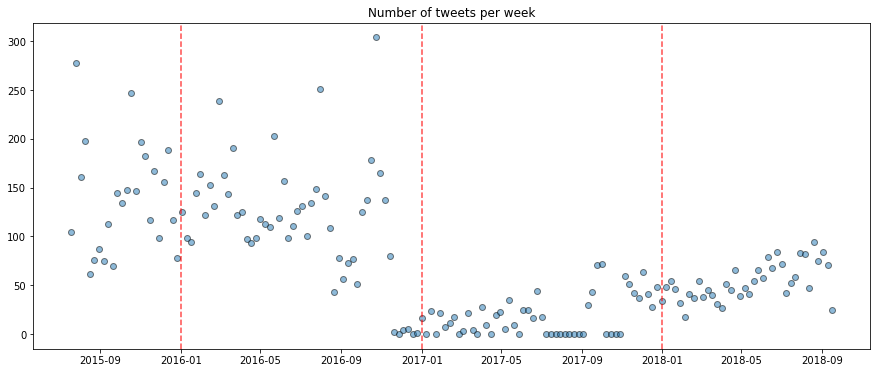

In [17]:
import numpy as np


df_merged['Date'] = pd.to_datetime(df_merged['Date'])

twts_day = df_merged.groupby(pd.Grouper(key='Date',freq='W')).count()['Text']
plt.figure(figsize=(15,6))

df_twts_day = pd.DataFrame({'date': twts_day.index,
                            'tweets': twts_day.values},
                            columns=['date','tweets'])


plt.scatter(x=df_twts_day['date'],y=df_twts_day['tweets'],alpha=0.5,edgecolor='black')

plt.axvline(x='2016-01-01',ls='--',color='red',alpha=0.7)
plt.axvline(x='2017-01-01',ls='--',color='red',alpha=0.7)
plt.axvline(x='2018-01-01',ls='--',color='red',alpha=0.7)
plt.title('Number of tweets per week')
plt.show()


There is a change of number of tweets in the time period. The twitter activity was much higher before becoming president. Once Donald became president the tweets dropped more than 50% the first week and then the number of tweets gradually increased from spring to late summer in 2018. Since the number of tweets changed so much before and after the presidential election. Let's have a closer look of the activity during different parts of the day.

In [18]:
import datetime

def categorise_time(time):
    """
    Categorise parts of the day 
    depending on the hours.
    INPUT: Hour component of the tweet time
    OUTPUT: Returns Morning, Afternoon, Evening or Night 
            depending on the hour.
    """

 
    if  5<=  int(time.hour) <12:
        return "Morning"
    if  12<=  int(time.hour) <17:
        return "Afternoon"
    if  17<=  int(time.hour) <21:
        return "Evening"
    else: # 21<=  int(time.hour) <5:
        return "Night"
 
    
    
df_merged['time1'] = pd.to_datetime(df_merged['Time'])

df_merged['part_of_day'] = df_merged.apply(lambda x: categorise_time(x['time1']),axis=1).copy()
#df_merged.head()
df_merged[df_merged['Text']==""]

,Date,Time,Text,Year,Retweets,time1,part_of_day
8,2016-11-09,01:35:15,,2016,17169.0,2020-12-10 01:35:15,Night
9,2016-11-08,23:20:39,,2016,19710.0,2020-12-10 23:20:39,Night
10,2016-11-08,23:20:09,,2016,11287.0,2020-12-10 23:20:09,Night
20,2016-11-08,04:32:51,,2016,9176.0,2020-12-10 04:32:51,Night
22,2016-11-08,04:27:18,,2016,6917.0,2020-12-10 04:27:18,Night
...,...,...,...,...,...,...,...
10704,2018-06-05,20:37:50,,2018,9960.0,2020-12-10 20:37:50,Evening
10743,2018-06-02,16:28:53,,2018,11932.0,2020-12-10 16:28:53,Afternoon
11113,2018-04-14,01:31:56,,2018,34859.0,2020-12-10 01:31:56,Night
11206,2018-03-30,20:24:56,,2018,24341.0,2020-12-10 20:24:56,Evening


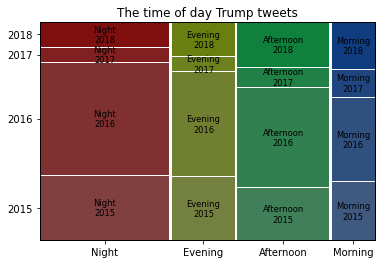

In [19]:
from statsmodels.graphics.mosaicplot import mosaic
df_merged_sorted = df_merged.sort_values(by='Year',ascending=True)
mosaic(df_merged_sorted, ['part_of_day','Year'], title='The time of day Trump tweets',gap=0.007,horizontal=True)

plt.show()

The mosaic plot shows the relationship between each box. The widths of the boxes are proportional to the percentage of the days (Afternoon, evening, night and morning) and the heights of the boxes are proportional to the years (2015, 2016, 2017, 2018). Overall the <i>2016</i> boxes are bigger than the other years and the <i>Night</i> boxes are bigger than other parts of the day. To conclude, the tweets occurred mostly during night regardless of the year and second most occurrence is during afternoon.


In [20]:
# Another way to show is with crosstab  
#pd.crosstab(df_merged_sorted['part_of_day'],df_merged_sorted['Year'])

## Sentiment analysis <a id='Sentiment-analysis'></a>



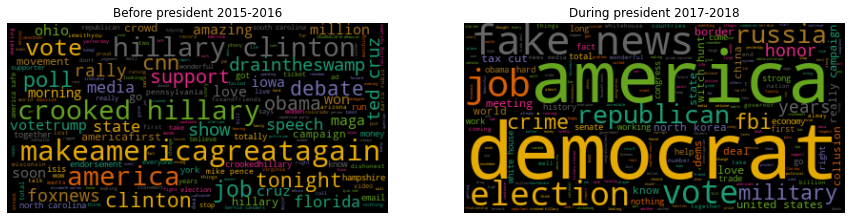

In [21]:
update_stop_words = STOPWORDS.union({'S','U','big','much','time','want','many','done','one','Trump',
                                     'back','said','see','need','great','people','thank','American',
                                    'must','don t', 'good', 'going','win','even','now','must','don',
                                     'today','join','new','will','never','country','year','better',
                                     'way','bad', 't','make','dem','way','thing','say','day','made',
                                    'last','night','tomorrow','interviewed','watch','look','let','US',
                                    'president'})
#cv = CountVectorizer(max_df=0.3,                                              
#                     stop_words="english", 
#                     max_features=500)

#counts = cv.fit_transform(df_merged['Text']).toarray()

update_stop_words = STOPWORDS.union(update_stop_words)

fig, axes = plt.subplots(1,2,squeeze=False,figsize=(15,15))

wordcloud2016 = WordCloud(max_words=400, background_color="black",
                          colormap='Dark2',random_state=72,
                          stopwords = update_stop_words,
                          max_font_size=250).generate(text2016)

wordcloud2017 = WordCloud(max_words=400, background_color="black",
                          colormap='Dark2',random_state=72,
                          stopwords = update_stop_words,
                          max_font_size=200).generate(text2017)

axes[0][0].imshow(wordcloud2016, interpolation='bilinear')
axes[0][1].imshow(wordcloud2017, interpolation='bilinear')
axes[0][0].title.set_text('Before president 2015-2016')
axes[0][1].title.set_text('During president 2017-2018')
axes[0][0].axis('off')
axes[0][1].axis('off')
plt.show()

From the wordcloud <i>Before president 2015-2016</i> it is clear that the tweets were a lot presidential election related. I have also included the hashtag words in his tweets (ex makeamericagreatagain). By adding a hashtag, it increases the chance someone interested in the event will engage so I thought it would be interesting to see which hashtags he chose. During the first 1.5 years as a president, the focus was on different subjects. The tweets were now more related to domestic politics, the news that was claimed to be fake and job. 

We have a picture now how and when he tweeted. Let's finalize with how the sentiments were for the tweets. 

In [22]:
# Store the sentiment in a list
pol = []
sub = []
for text in df_merged['Text']:
    pol.append(TextBlob(text).sentiment.polarity)
    sub.append(TextBlob(text).sentiment.subjectivity)


In [23]:
# Create a dataframe of the sentiments
# Concatenate the two dataframes into one
df_sentiment = pd.DataFrame({'polarity':pol,
                         'subjectivity':sub})


df = pd.concat([df_merged,df_sentiment], axis=1)
df.sort_values(by='Date',inplace=True)
#df.head()

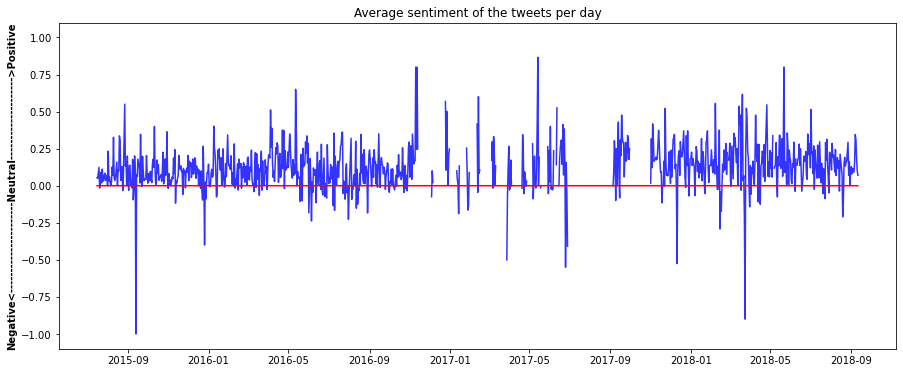

In [24]:
# Average the tweets sentiments per day
df_sentiment_day = df.groupby(pd.Grouper(key='Date',freq='d')).mean()
df_sentiment_day.reset_index(inplace=True)


plt.figure(figsize=(15,6))
plt.plot(df_sentiment_day['Date'],df_sentiment_day['polarity'],color='blue',alpha=0.8)
plt.plot(df_sentiment_day['Date'],np.zeros(len(df_sentiment_day)),linestyle='-',color='red')
plt.ylim([-1.1,1.1])
plt.title('Average sentiment of the tweets per day')
plt.ylabel('Negative<----------------------Neutral-------------------->Positive', fontweight='bold')
plt.show()

The average sentiment per day tweets were in general positive. The last half of presidential election period the tweets were more negative when the election approched to an end the tweets started to become more positive. Unfortunatley there are some missing data in the data sets I have used, which explains why there are some gaps in the plot. 

## Conclusion <a id='conclusion'></a>

In this project I have explored the tweets from three different data sets from autumn 2015 to autumn 2018. Number of tweets were analysed and during what part of the day the tweets occurred the most. Wordclouds were used to see the most meaningful words that were tweeted before president and during the presidential period. Lastly, a sentiment analysis was performed to see the average tweets sentiment per day.

Unfortunately some certain time periods were missing from the data sets and some data sets didn't have a number of retweets or likes. Otherwise it would be interesting to see any pattern between the tweets ,likes and retweets.